# 1. Importing Packages and Collecting Data, Defining Evaluation 

## 1.1 Importing Packages

In [1]:
'''Importing Data Manipulattion Modules'''
import re
import numpy as np
import pandas as pd
from pandas.core.dtypes.dtypes import CategoricalDtype
from scipy.stats import norm, skew
from scipy.special import boxcox1p
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
pd.set_option("display.max_columns", 81)
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_colwidth", 100)

'''Seaborn and Matplotlib Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')                    
sns.set_style({'axes.grid':False}) 
sns.set_style('whitegrid')
%matplotlib inline

'''Validation'''
from sklearn.model_selection import KFold, cross_val_score

'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

## 1.2 Collecting Data

In [11]:
'''Check the files'''
from subprocess import check_output
# print(check_output(["ls", "./grupo-bimbo-inventory-demand"]).decode("utf8"))

### town_state

In [12]:
dtype = {'Agencia_ID': 'int16'}
town_state_df = pd.read_csv("./grupo-bimbo-inventory-demand/town_state.csv", dtype=dtype)

town_state_df['Town_ID'] = town_state_df.Town.apply(lambda x: x.split(' ')[0]).astype('int16')
town_state_df['Town_name'] = town_state_df.Town.apply(lambda x: ' '.join(x.split(' ')[1:]))

print(f'town_state\'s shape: {town_state_df.shape}')
town_state_df.head(5)

town_state's shape: (790, 5)


,Agencia_ID,Town,State,Town_ID,Town_name
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F.",2002,AG. AZCAPOTZALCO
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO,2004,AG. CUAUTITLAN
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F.",2029,AG.IZTAPALAPA 2


In [13]:
town_state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Agencia_ID  790 non-null    int16 
 1   Town        790 non-null    object
 2   State       790 non-null    object
 3   Town_ID     790 non-null    int16 
 4   Town_name   790 non-null    object
dtypes: int16(2), object(3)
memory usage: 21.7+ KB


### product

In [15]:
dtype = {'Producto_ID': 'int32'}
product_df = pd.read_csv("./grupo-bimbo-inventory-demand/producto_tabla.csv", dtype=dtype)

product_df['popular_name'] = product_df.NombreProducto.str.extract(r'^(.*?)(\d*\s\d+(kg|Kg|g|G|ml| ml|p|Reb)\s)', expand=False)[0]
product_df['property'] = product_df.NombreProducto.str.extract(r'^.*\d+(kg|Kg|g|G|ml| ml|p|Reb)\s(.*?)\s\d+$', expand=False)[1]
product_df['unit'] = product_df.NombreProducto.str.extract(r'(\d*\s\d+(kg|Kg|g|G|ml| ml))', expand=False)[0]
product_df['pieces'] =  product_df.NombreProducto.str.extract('(\d+(p|Reb)) ', expand=False)[0]

print(f'product\'s shape: {product_df.shape}')
product_df.head(5)

product's shape: (2592, 6)


,Producto_ID,NombreProducto,popular_name,property,unit,pieces
0,0,NO IDENTIFICADO 0,NaN,NaN,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NES,750g,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,480g,6p
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,CU LON,170g,NaN
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,TR,45g,4p


In [16]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Producto_ID     2592 non-null   int32 
 1   NombreProducto  2592 non-null   object
 2   popular_name    2565 non-null   object
 3   property        2571 non-null   object
 4   unit            2532 non-null   object
 5   pieces          1132 non-null   object
dtypes: int32(1), object(5)
memory usage: 111.5+ KB


### client

In [18]:
dtype = {'Cliente_ID': 'int32'}
client_df = pd.read_csv("./grupo-bimbo-inventory-demand/cliente_tabla.csv", dtype=dtype)

dup_sr = client_df.groupby('Cliente_ID')['Cliente_ID'].count().astype('int8')
dup_sr.name = 'dup_num'
client_df = pd.merge(client_df, pd.DataFrame(dup_sr).reset_index())
del dup_sr

print(f'client\'s shape: {client_df.shape}')
client_df.head(5)

client's shape: (935362, 3)


,Cliente_ID,NombreCliente,dup_num
0,0,SIN NOMBRE,1
1,1,OXXO XINANTECATL,1
2,2,SIN NOMBRE,1
3,3,EL MORENO,1
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,2


In [19]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935362 entries, 0 to 935361
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Cliente_ID     935362 non-null  int32 
 1   NombreCliente  935362 non-null  object
 2   dup_num        935362 non-null  int8  
dtypes: int32(1), int8(1), object(1)
memory usage: 18.7+ MB


### test

In [21]:
dtype = {
    'id': 'int32',
    'Semana': 'int8',
    'Agencia_ID': 'int16',
    'Canal_ID': 'int8',
    'Ruta_SAK': 'int16',
    'Cliente_ID': 'int32',
    'Producto_ID': 'int32',
}
test_df = pd.read_csv("./grupo-bimbo-inventory-demand/test.csv", dtype=dtype)

print(f'test\'s shape: {test_df.shape}')
test_df.head()

test's shape: (6999251, 7)


,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999251 entries, 0 to 6999250
Data columns (total 7 columns):
 #   Column       Dtype
---  ------       -----
 0   id           int32
 1   Semana       int8 
 2   Agencia_ID   int16
 3   Canal_ID     int8 
 4   Ruta_SAK     int16
 5   Cliente_ID   int32
 6   Producto_ID  int32
dtypes: int16(2), int32(3), int8(2)
memory usage: 120.2 MB


### train

In [24]:
dtype = {
    'Semana': 'int8',
    'Agencia_ID': 'int16',
    'Canal_ID': 'int8',
    'Ruta_SAK': 'int16',
    'Cliente_ID': 'int32',
    'Producto_ID': 'int32',
    'Venta_uni_hoy': 'int16',
    'Venta_hoy': 'float32',
    'Dev_uni_proxima': 'int32',
    'Dev_proxima': 'float32',
    'Demanda_uni_equil': 'int16',
}
train_df = pd.read_csv("./grupo-bimbo-inventory-demand/train.csv", dtype=dtype)

print(f'train\'s shape: {train_df.shape}')
train_df.head()

train's shape: (74180464, 11)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.140,0,0.000,3
1,3,1110,7,3301,15766,1216,4,33.520,0,0.000,4
2,3,1110,7,3301,15766,1238,4,39.320,0,0.000,4
3,3,1110,7,3301,15766,1240,4,33.520,0,0.000,4
4,3,1110,7,3301,15766,1242,3,22.920,0,0.000,3


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Semana             int8   
 1   Agencia_ID         int16  
 2   Canal_ID           int8   
 3   Ruta_SAK           int16  
 4   Cliente_ID         int32  
 5   Producto_ID        int32  
 6   Venta_uni_hoy      int16  
 7   Venta_hoy          float32
 8   Dev_uni_proxima    int32  
 9   Dev_proxima        float32
 10  Demanda_uni_equil  int16  
dtypes: float32(2), int16(4), int32(3), int8(2)
memory usage: 2.1 GB


### product_price

In [26]:
sale_price_sr = (train_df.Venta_hoy / train_df.Venta_uni_hoy)
return_price_sr = (train_df.Dev_proxima / train_df.Dev_uni_proxima)
product_price_df = pd.DataFrame({'Producto_ID': train_df.Producto_ID, 'sale_price': sale_price_sr, 'return_price': return_price_sr})

del sale_price_sr
del return_price_sr

print(f'product price\'s shape: {product_price_df.shape}')
product_price_df.head(5)

product price's shape: (74180464, 3)


,Producto_ID,sale_price,return_price
0,1212,8.380,NaN
1,1216,8.380,NaN
2,1238,9.830,NaN
3,1240,8.380,NaN
4,1242,7.640,NaN


In [27]:
product_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Producto_ID   int32  
 1   sale_price    float32
 2   return_price  float32
dtypes: float32(2), int32(1)
memory usage: 848.9 MB


## 1.3 Defining Evaluation

In [28]:
'''KFold for cross validation'''
kf = KFold(n_splits=3, shuffle=True, random_state=2)

'''Define the validation function'''
def rmsle_cv(model, X, y, cv=kf):
    rmsle = np.sqrt(
        -cross_val_score(
            model,
            X, y,
            scoring="neg_mean_squared_log_error",
            cv=cv,
        )
    )
    return(rmsle)

# 2. Adjusting Data

## 2.1 Cleansing

### town_state

In [29]:
town_state_df['Town'] = town_state_df['Town'].str.upper()
town_state_df['Town_name'] = town_state_df['Town_name'].str.upper()
town_state_df['State'] = town_state_df['State'].str.upper()

In [30]:
town_state_df.groupby(['Town_name'])['Town_ID'].nunique().sort_values(ascending=False)[:6]

Town_name
PINOTEPA       2
LOS MOCHIS     2
ACAPONETA      1
NOGALES_BW     1
NORTE          1
NUEVO IDEAL    1
Name: Town_ID, dtype: int64

In [31]:
town_state_df[(town_state_df['Town_name'].isin(['LOS MOCHIS', 'PINOTEPA']))].sort_values(by='Town_name')

,Agencia_ID,Town,State,Town_ID,Town_name
211,1544,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
227,1564,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
248,1598,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
498,2655,2655 LOS MOCHIS,SINALOA,2655,LOS MOCHIS
774,25619,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
372,2023,2169 PINOTEPA,OAXACA,2169,PINOTEPA
387,2055,2055 PINOTEPA,PUEBLA,2055,PINOTEPA
599,21699,2169 PINOTEPA,OAXACA,2169,PINOTEPA


In [32]:
town_state_df.loc[498, 'Town_ID'] = 2561

In [33]:
town_state_df.head(5)

,Agencia_ID,Town,State,Town_ID,Town_name
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F.",2002,AG. AZCAPOTZALCO
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO,2004,AG. CUAUTITLAN
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F.",2029,AG.IZTAPALAPA 2


In [34]:
town_state_df.groupby('Town_ID')['Town'].nunique().sort_values(ascending=False)

Town_ID
2169    2
2152    2
2561    2
2001    1
2391    1
       ..
2257    1
2258    1
2259    1
2260    1
3216    1
Name: Town, Length: 256, dtype: int64

In [35]:
town_state_df[town_state_df.Town_ID.isin([2561, 2169, 2152])].sort_values(by='Town_ID')

,Agencia_ID,Town,State,Town_ID,Town_name
199,1524,2152 CRUCE DE ANDEN NOROESTE,BAJA CALIFORNIA NORTE,2152,CRUCE DE ANDEN NOROESTE
371,2022,2152 ALTAMIRANO_BM,GUERRERO,2152,ALTAMIRANO_BM
583,21529,2152 ALTAMIRANO_BM,GUERRERO,2152,ALTAMIRANO_BM
311,1694,2169 CRUCE DE ANDÉN SURESTE,PUEBLA,2169,CRUCE DE ANDÉN SURESTE
372,2023,2169 PINOTEPA,OAXACA,2169,PINOTEPA
599,21699,2169 PINOTEPA,OAXACA,2169,PINOTEPA
211,1544,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
227,1564,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
248,1598,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
498,2655,2655 LOS MOCHIS,SINALOA,2561,LOS MOCHIS


In [36]:
town_state_df['Town_ID'].max()

3216

In [37]:
town_state_df.loc[199, 'Town_ID'] = 3217
town_state_df.loc[311, 'Town_ID'] = 3218

In [38]:
town_state_df['Town_ID'].nunique()

258

### product_price

In [39]:
sale_prices_df = product_price_df.drop('return_price', axis=1).dropna().rename(columns={'sale_price': 'price'})
return_prices_df = product_price_df.drop('sale_price', axis=1).dropna().rename(columns={'return_price': 'price'})
prices_df = pd.concat([sale_prices_df, return_prices_df])
prices_df = prices_df.groupby('Producto_ID')['price'].median().reset_index()
prices_df.head(5)

,Producto_ID,price
0,41,18.130
1,53,14.300
2,72,3.700
3,73,21.320
4,100,21.580


In [40]:
prices_df.shape

(1799, 2)

### product

In [41]:
product_df['in_train'] = 0
product_df['in_test'] = 0
product_df.loc[product_df['Producto_ID'].isin(test_df['Producto_ID'].unique()), 'in_test'] = 1
product_df.loc[product_df['Producto_ID'].isin(train_df['Producto_ID'].unique()), 'in_train'] = 1
product_df = product_df[(product_df['in_test'] == 1) | (product_df['in_train'] == 1)]

In [42]:
product_df[product_df['property'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test
117,1289,Donas 6P Prom BIM 1289,NaN,NaN,NaN,NaN,1,0
190,3509,Paletina para Cafe NES 3509,NaN,NaN,NaN,NaN,1,0
381,30099,Camioncitos Bimbo BIM 30099,NaN,NaN,NaN,NaN,1,1
1152,34646,Burrito Vaporero FrijolChorizo90gCU LON 34646,NaN,NaN,NaN,NaN,1,1
1677,36659,Tarima Twin Pack Thins Multig CU ORO 36659,NaN,NaN,NaN,NaN,1,1
1888,37569,Deliciosas Chochochispas 204gPromMTA LAR 37569,NaN,NaN,204g,NaN,1,1
1889,37570,Deliciosas Chochochispas 204gProm LAR 37570,NaN,NaN,204g,NaN,1,1
2449,48033,Galleta Granel Classics Chocolate GBI 48033,NaN,NaN,NaN,NaN,1,1


In [43]:
product_df.loc[117, 'popular_name'] = 'Donas'
product_df.loc[117, 'property'] = 'Prom BIM'
product_df.loc[117, 'unit'] = None
product_df.loc[117, 'pieces'] = '6p'

product_df.loc[190, 'popular_name'] = 'Paletina para Cafe'
product_df.loc[190, 'property'] = 'NES'
product_df.loc[190, 'unit'] = None
product_df.loc[190, 'pieces'] = None

product_df.loc[381, 'popular_name'] = 'Camioncitos Bimbo'
product_df.loc[381, 'property'] = 'BIM'
product_df.loc[381, 'unit'] = None
product_df.loc[381, 'pieces'] = None

product_df.loc[1152, 'popular_name'] = 'Burrito Vaporero FrijolChorizo'
product_df.loc[1152, 'property'] = 'CU LON'
product_df.loc[1152, 'unit'] = '90g'
product_df.loc[1152, 'pieces'] = None

product_df.loc[1677, 'popular_name'] = 'Tarima Twin Pack Thins Multig'
product_df.loc[1677, 'property'] = 'CU ORO'
product_df.loc[1677, 'unit'] = None
product_df.loc[1677, 'pieces'] = None

product_df.loc[1888, 'popular_name'] = 'Deliciosas Chochochispas'
product_df.loc[1888, 'property'] = 'Prom MTA LAR'
product_df.loc[1888, 'unit'] = '204g'
product_df.loc[1888, 'pieces'] = None

product_df.loc[1889, 'popular_name'] = 'Deliciosas Chochochispas'
product_df.loc[1889, 'property'] = 'Prom LAR'
product_df.loc[1889, 'unit'] = '204g'
product_df.loc[1889, 'pieces'] = None

product_df.loc[2449, 'popular_name'] = 'Galleta Granel Classics Chocolate'
product_df.loc[2449, 'property'] = 'GBI'
product_df.loc[2449, 'unit'] = None
product_df.loc[2449, 'pieces'] = None

In [44]:
product_df[product_df['popular_name'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test
877,32841,Tortilla Hna Chihuahua 10p535g SP MTA DH 32841,NaN,SP MTA DH,NaN,NaN,1,1
1585,36323,Principe Cho Bco MG 10p110g Prom CR1 MLA 36323,NaN,Prom CR1 MLA,NaN,NaN,1,1
1748,36927,Combo Salma mas Levite1360g Prom CUB SAN 36927,NaN,Prom CUB SAN,NaN,NaN,1,0


In [45]:
product_df.loc[877, 'popular_name'] = 'Tortilla Hna Chihuahua'
product_df.loc[877, 'unit'] = '535g'
product_df.loc[877, 'pieces'] = '10p'

product_df.loc[1585, 'popular_name'] = 'Principe Cho Bco MG'
product_df.loc[1585, 'unit'] = '110g'
product_df.loc[1585, 'pieces'] = '10p'

product_df.loc[1748, 'popular_name'] = 'Combo Salma mas Levite'
product_df.loc[1748, 'unit'] = '1360g'
product_df.loc[1748, 'pieces'] = None

In [46]:
product_df['pieces'] = product_df['pieces'].str.extract(r'(\d+)(p|Reb)')[0]

In [47]:
product_df['weight'] = product_df['unit'].str.strip()
product_df['weight'] = product_df['weight'].str.replace(' ', '.')
product_df['weight'] = product_df['weight'].str.upper()
w = product_df['weight'].str.extract('(.+?)(KG|G|ML)', expand=True)
product_df['weight'] = w[0].astype('float') * w[1].map({'KG':1000, 'G':1, 'ML':1})

In [48]:
product_df = pd.merge(product_df, prices_df, how='left')

## 2.2 Imputing Missing Data

### product

In [49]:
product_df['pieces'] = product_df['pieces'].fillna(1)

In [50]:
product_df[product_df['weight'].isnull()]['price'].max()

311.0

In [51]:
product_df[product_df['price'].isnull()]['weight'].max()

1880.0

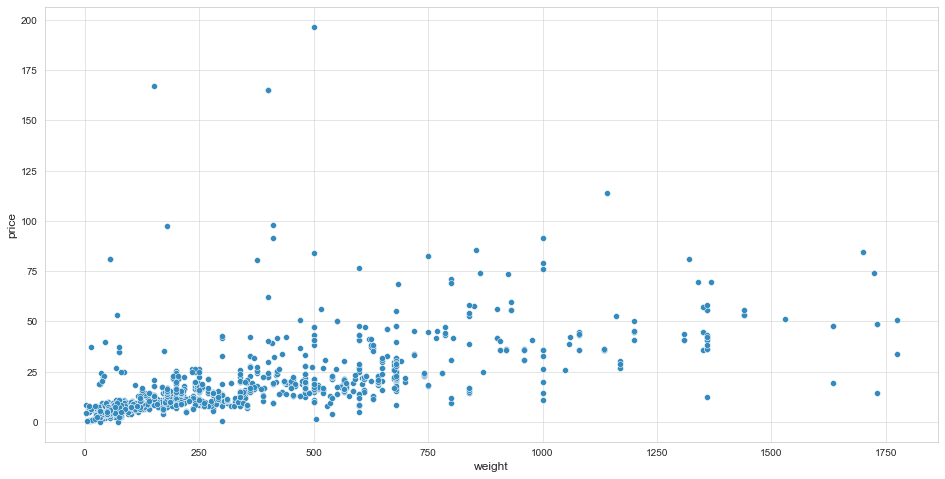

In [52]:
df = product_df.dropna()
df = df[(df['price'] <= 311) & (df['weight'] <= 1880)]
plt.figure(figsize=(16,8))
sns.scatterplot(x='weight', y='price', data=df)
del df

In [53]:
from sklearn.linear_model import LinearRegression

df = product_df.dropna()
df = df[(df['price'] <= 100) & (df['weight'] <= 1880)]

# predict missing prices
lf = LinearRegression()
lf.fit(df['weight'].values.reshape(-1, 1), df['price'])

prices = lf.predict(product_df[product_df['price'].isnull()]['weight'].values.reshape(-1, 1))

product_df.loc[product_df['price'].isnull(), 'price'] = prices

# predict missing weights
lf = LinearRegression()
lf.fit(df['price'].values.reshape(-1, 1), df['weight'])

weights = lf.predict(product_df[product_df['weight'].isnull()]['price'].values.reshape(-1, 1))

product_df.loc[product_df['weight'].isnull(), 'weight'] = weights

del df
del prices
del weights

In [54]:
(product_df.drop(['unit'], axis=1).isnull().sum() == 0).all()

True

## 2.3 Transforming Data Type

In [55]:
product_df['pieces'] = product_df['pieces'].astype('int16')
product_df['in_train'] = product_df['in_train'].astype('bool')
product_df['in_test'] = product_df['in_test'].astype('bool')
product_df['weight'] = product_df['weight'].astype('float32')
product_df['price'] = product_df['price'].astype('float32')

In [56]:
town_state_df['State'] = town_state_df['State'].astype('category')

In [57]:
train_df['Canal_ID'] = train_df['Canal_ID'].astype('category')
test_df['Canal_ID'] = test_df['Canal_ID'].astype('category')

## 2.4 Dropping Features

In [58]:
train_df.drop(['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima'], axis=1, inplace=True)

## 2.5 Merging Data

### town_state

In [59]:
train_df = pd.merge(train_df, town_state_df[['Agencia_ID', 'Town_ID']], how='left')
test_df = pd.merge(test_df, town_state_df[['Agencia_ID', 'Town_ID']], how='left')
train_df.drop('Agencia_ID', axis=1, inplace=True)
test_df.drop('Agencia_ID', axis=1, inplace=True)

### product

In [60]:
train_df = pd.merge(
    train_df,
    product_df[[
        'Producto_ID', 'popular_name', 'property',
        'pieces', 'weight', 'price'
    ]], how='left')
test_df = pd.merge(
    test_df,
    product_df[[
        'Producto_ID', 'popular_name', 'property',
        'pieces', 'weight', 'price'
    ]], how='left')

In [61]:
train_df.head(5)

,Semana,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Town_ID,popular_name,property,pieces,weight,price
0,3,7,3301,15766,1212,3,2008,Roles Canela,BIM,2,120.000,8.380
1,3,7,3301,15766,1216,4,2008,Roles Glass,BIM,2,135.000,8.380
2,3,7,3301,15766,1238,4,2008,Panquecito Gota Choc,BIM,2,140.000,9.830
3,3,7,3301,15766,1240,4,2008,Mantecadas Vainilla,BIM,4,125.000,8.380
4,3,7,3301,15766,1242,3,2008,Donitas Espolvoreadas,BIM,6,105.000,7.640


## 2.6 Bin-Counting

### Semana

In [62]:
semana_med_s = train_df.groupby('Semana')['Demanda_uni_equil'].median()

In [63]:
semana_med_s

Semana
3   3.000
4   3.000
5   3.000
6   3.000
7   3.000
8   3.000
9   3.000
Name: Demanda_uni_equil, dtype: float64

In [64]:
train_df.drop('Semana', axis=1, inplace=True)
test_df.drop('Semana', axis=1, inplace=True)
del semana_med_s

### Cliente_ID

In [65]:
client_med_s = train_df.groupby('Cliente_ID')['Demanda_uni_equil'].median().astype('int16')
client_med_s.name = 'client_med'

### popular_name

In [66]:
popular_name_med_s = train_df.groupby('popular_name')['Demanda_uni_equil'].median().astype('int16')
popular_name_med_s.name = 'popular_name_med'

### Town_ID

In [67]:
town_id_med_s = train_df.groupby('Town_ID')['Demanda_uni_equil'].median().astype('int16')
town_id_med_s.name = 'town_id_med'

### Ruta_SAK

In [68]:
ruta_id_med_s = train_df.groupby('Ruta_SAK')['Demanda_uni_equil'].median().astype('int16')
ruta_id_med_s.name = 'ruta_id_med'

## 2.7 Merging Bin-Counting Data

In [69]:
test_df = pd.merge(test_df, client_med_s.reset_index(), how='left')
test_df = pd.merge(test_df, popular_name_med_s.reset_index(), how='left')
test_df = pd.merge(test_df, town_id_med_s.reset_index(), how='left')
test_df = pd.merge(test_df, ruta_id_med_s.reset_index(), how='left')

In [70]:
train_df = pd.merge(train_df, client_med_s.reset_index(), how='left')
train_df = pd.merge(train_df, popular_name_med_s.reset_index(), how='left')
train_df = pd.merge(train_df, town_id_med_s.reset_index(), how='left')
train_df = pd.merge(train_df, ruta_id_med_s.reset_index(), how='left')

## 2.8 Imputing Test Missing Data

In [71]:
test_df['popular_name_med'] = test_df['popular_name_med'].fillna(test_df['popular_name_med'].mean())
test_df['client_med'] = test_df['client_med'].fillna(test_df['client_med'].mean())
test_df['ruta_id_med'] = test_df['ruta_id_med'].fillna(test_df['ruta_id_med'].mean())

## 2.9 Transforming Data Type

In [72]:
train_df['client_med'] = train_df['client_med'].astype('int16')
train_df['popular_name_med'] = train_df['popular_name_med'].astype('int16')
train_df['town_id_med'] = train_df['town_id_med'].astype('int16')
train_df['ruta_id_med'] = train_df['ruta_id_med'].astype('int16')

In [73]:
test_df['client_med'] = test_df['client_med'].astype('int16')
test_df['popular_name_med'] = test_df['popular_name_med'].astype('int16')
test_df['town_id_med'] = test_df['town_id_med'].astype('int16')
test_df['ruta_id_med'] = test_df['ruta_id_med'].astype('int16')

## 2.10 Dropping Features

In [74]:
train_df.drop(
    ['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'],
    axis=1, inplace=True)
test_df.drop(
    ['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'],
    axis=1, inplace=True)

In [75]:
train_df.head(3)

,Canal_ID,Demanda_uni_equil,weight,price,client_med,popular_name_med,town_id_med,ruta_id_med
0,7,3,120.000,8.380,4,2,5,5
1,7,4,135.000,8.380,4,2,5,5
2,7,4,140.000,9.830,4,2,5,5


In [76]:
test_df.head(3)

,id,Canal_ID,weight,price,client_med,popular_name_med,town_id_med,ruta_id_med
0,0,1,75.000,6.250,2,6,3,3
1,1,1,140.000,9.830,2,2,3,2
2,2,1,110.000,7.780,4,3,3,3


# 3. Data Preprocessing

## 3.1 Take a glance at all variables

In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74180464 entries, 0 to 74180463
Data columns (total 8 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Canal_ID           category
 1   Demanda_uni_equil  int16   
 2   weight             float32 
 3   price              float32 
 4   client_med         int16   
 5   popular_name_med   int16   
 6   town_id_med        int16   
 7   ruta_id_med        int16   
dtypes: category(1), float32(2), int16(5)
memory usage: 1.9 GB


In [78]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6999251 entries, 0 to 6999250
Data columns (total 8 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                int32   
 1   Canal_ID          category
 2   weight            float32 
 3   price             float32 
 4   client_med        int16   
 5   popular_name_med  int16   
 6   town_id_med       int16   
 7   ruta_id_med       int16   
dtypes: category(1), float32(2), int16(4), int32(1)
memory usage: 193.6 MB


In [79]:
train_df.describe()

,Demanda_uni_equil,weight,price,client_med,popular_name_med,town_id_med,ruta_id_med
count,74180464.000,74180464.000,74180464.000,74180464.000,74180464.000,74180464.000,74180464.000
mean,7.225,128.986,7.203,4.429,4.447,3.423,3.844
std,21.771,195.477,6.606,9.387,7.788,2.080,6.092
min,0.000,1.700,0.010,0.000,0.000,2.000,0.000
25%,2.000,80.000,6.760,2.000,2.000,3.000,3.000
50%,3.000,120.000,8.380,3.000,3.000,3.000,3.000
75%,6.000,255.000,12.590,4.000,4.000,4.000,4.000
max,5000.000,25000.000,6412.330,4983.000,3000.000,2304.000,3168.000


In [80]:
test_df.describe()

,id,weight,price,client_med,popular_name_med,town_id_med,ruta_id_med
count,6999251.000,6999251.000,6999251.000,6999251.000,6999251.000,6999251.000,6999251.000
mean,3499625.000,198.181,10.154,4.460,4.458,3.429,3.859
std,2020509.869,203.363,6.171,9.429,7.723,1.914,5.990
min,0.000,1.700,0.410,0.000,0.000,2.000,2.000
25%,1749812.500,76.000,6.250,2.000,2.000,3.000,3.000
50%,3499625.000,120.000,8.150,3.000,3.000,3.000,3.000
75%,5249437.500,255.000,13.940,4.000,4.000,4.000,4.000
max,6999250.000,25000.000,647.360,3920.000,1400.000,2304.000,1816.000


In [81]:
'''Plot histogram of numerical variables to validate pandas intuition.'''
def draw_histograms(df, variables, n_rows, n_cols, size):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        df[var_name].hist(bins=40, ax=ax, color='skyblue', alpha=0.8, figsize=size)
        ax.set_title(var_name, fontsize=43)
        ax.tick_params(axis='both', which='major', labelsize=35)
        ax.tick_params(axis='both', which='minor', labelsize=35)
        ax.set_xlabel('')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [82]:
skewness = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).apply(lambda x: skew(x))
skew_index = skewness[abs(skewness) >= 0.75].index
skewness[skew_index].sort_values(ascending=False)

town_id_med         570.474
client_med           94.001
price                91.813
popular_name_med     55.059
ruta_id_med          49.450
Demanda_uni_equil    43.038
weight                9.776
dtype: float64

In [83]:
skewness = test_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).apply(lambda x: skew(x))
skew_index = skewness[abs(skewness) >= 0.75].index
skewness[skew_index].sort_values(ascending=False)

town_id_med        503.272
client_med          89.683
popular_name_med    48.348
ruta_id_med         42.790
weight              10.287
price                7.391
dtype: float64

## 3.2 BoxCox Transform

In [84]:
'''BoxCox Transform'''
lam = 0.01
for column in skew_index:
    train_df[column] = boxcox1p(train_df[column], lam)
    test_df[column] = boxcox1p(test_df[column], lam)

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74180464 entries, 0 to 74180463
Data columns (total 8 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Canal_ID           category
 1   Demanda_uni_equil  int16   
 2   weight             float32 
 3   price              float32 
 4   client_med         float64 
 5   popular_name_med   float64 
 6   town_id_med        float64 
 7   ruta_id_med        float64 
dtypes: category(1), float32(2), float64(4), int16(1)
memory usage: 3.5 GB


In [86]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6999251 entries, 0 to 6999250
Data columns (total 8 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                int32   
 1   Canal_ID          category
 2   weight            float32 
 3   price             float32 
 4   client_med        float64 
 5   popular_name_med  float64 
 6   town_id_med       float64 
 7   ruta_id_med       float64 
dtypes: category(1), float32(2), float64(4), int32(1)
memory usage: 353.8 MB


## 3.3 Transforming Data Type

In [87]:
train_df['client_med'] = train_df['client_med'].astype('float32')
train_df['popular_name_med'] = train_df['popular_name_med'].astype('float32')
train_df['town_id_med'] = train_df['town_id_med'].astype('float32')
train_df['ruta_id_med'] = train_df['ruta_id_med'].astype('float32')

In [88]:
test_df['client_med'] = test_df['client_med'].astype('float32')
test_df['popular_name_med'] = test_df['popular_name_med'].astype('float32')
test_df['town_id_med'] = test_df['town_id_med'].astype('float32')
test_df['ruta_id_med'] = test_df['ruta_id_med'].astype('float32')

# 4. Exploratory Data Analysis 

## 4.1 Analyzing Target 

In [89]:
sample_train_df = train_df.sample(n=10000)
sample_train_df['log_target'] = np.log1p(sample_train_df['Demanda_uni_equil'])

In [90]:
sample_train_df.head(5)

,Canal_ID,Demanda_uni_equil,weight,price,client_med,popular_name_med,town_id_med,ruta_id_med,log_target
15223982,1,1,4.648,2.163,1.396,1.808,1.622,1.622,0.693
73974594,1,2,4.774,2.180,1.396,1.622,1.396,1.105,1.099
26300021,1,5,4.614,2.001,1.105,1.622,1.396,1.396,1.792
5813796,1,14,4.107,1.401,1.808,2.427,1.396,1.622,2.708
14828839,1,5,4.107,1.401,1.105,2.427,1.396,1.105,1.792


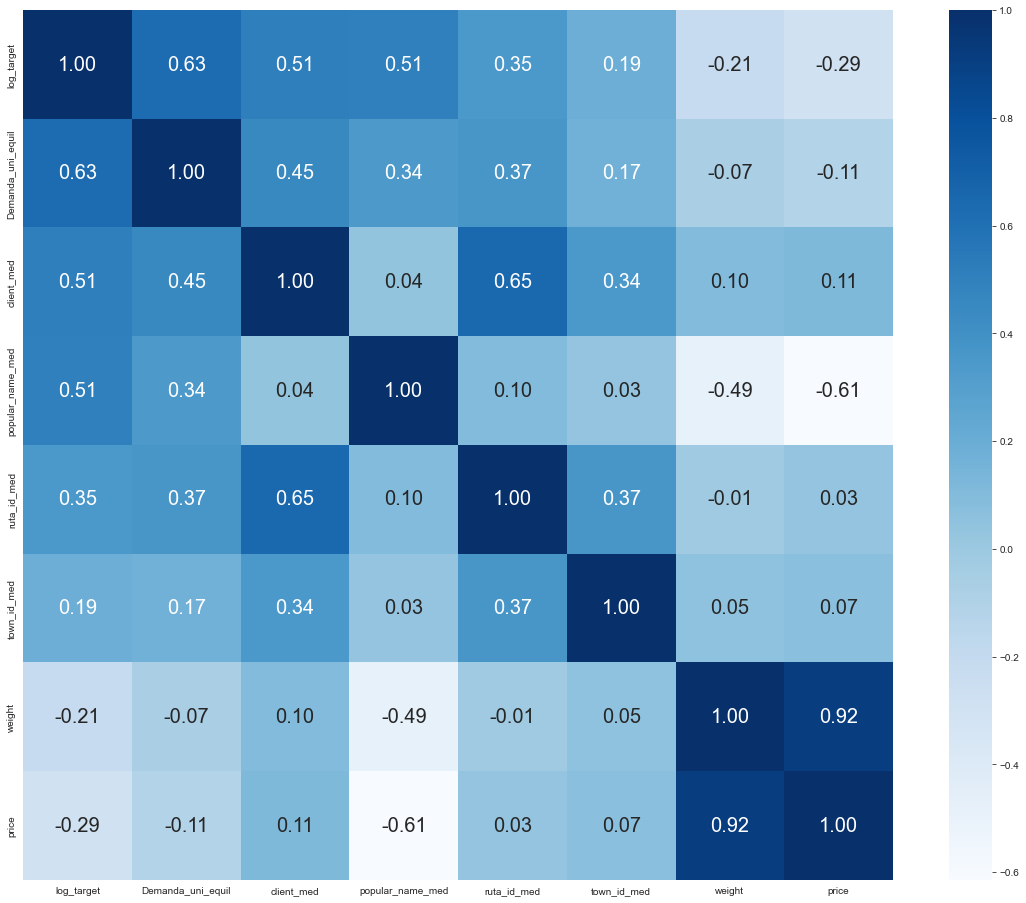

In [96]:
'''correlation matrix'''
plt.subplots(figsize=(20, 16))
k = 20 #number of variables for heatmap
corrmat = sample_train_df.corr()
cols = corrmat.nlargest(k, 'log_target')['log_target'].index

cm = np.corrcoef(sample_train_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 20}, cmap='Blues',
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [97]:
'''Check feature inportance by applying LightGBM'''
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(num_leaves=1000,
                              max_depth=5,
                              learning_rate=0.1,
                              random_state=2)
model_lgb.fit(sample_train_df.drop(['Demanda_uni_equil', 'log_target'], axis=1), sample_train_df['log_target'])

LGBMRegressor(max_depth=5, num_leaves=1000, random_state=2)

In [98]:
df = pd.DataFrame(model_lgb.feature_importances_,
             index=sample_train_df.drop(['Demanda_uni_equil', 'log_target'], axis=1).columns,
             columns=['importance']).sort_values('importance', ascending=False)
df[df.importance > 10]

,importance
client_med,467
price,404
weight,397
popular_name_med,267
ruta_id_med,249
town_id_med,88
Canal_ID,49


<AxesSubplot:xlabel='weight', ylabel='log_target'>

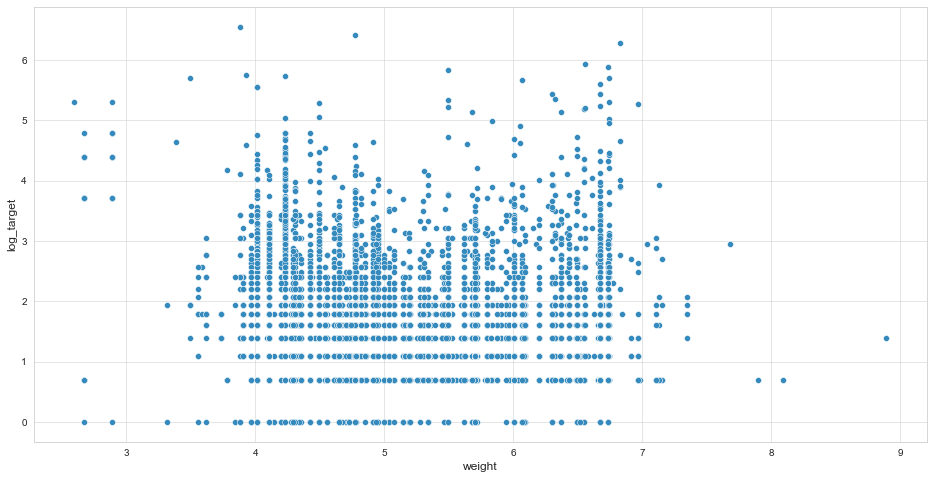

In [99]:
# weight
plt.figure(figsize=(16, 8))
sns.scatterplot(x='weight', y='log_target', data=sample_train_df, palette='Blues_d')

<AxesSubplot:xlabel='price', ylabel='log_target'>

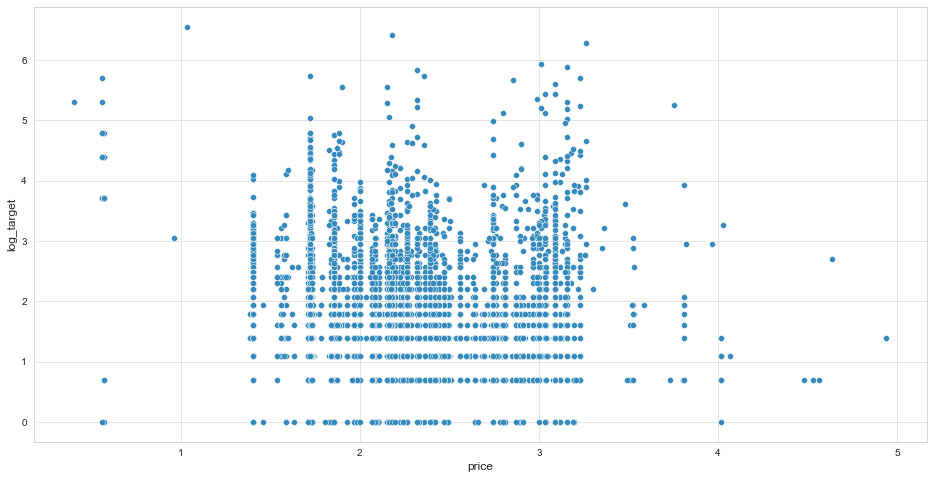

In [100]:
# price
plt.figure(figsize=(16, 8))
sns.scatterplot(x='price', y='log_target', data=sample_train_df, palette='Blues_d')

<AxesSubplot:xlabel='client_med', ylabel='log_target'>

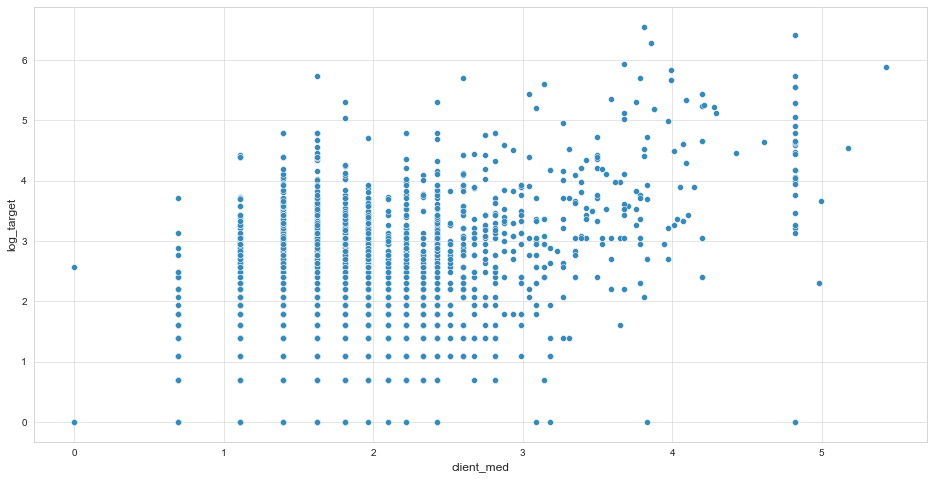

In [101]:
# client_med
plt.figure(figsize=(16, 8))
sns.scatterplot(x='client_med', y='log_target', data=sample_train_df, palette='Blues_d')

<AxesSubplot:xlabel='popular_name_med', ylabel='log_target'>

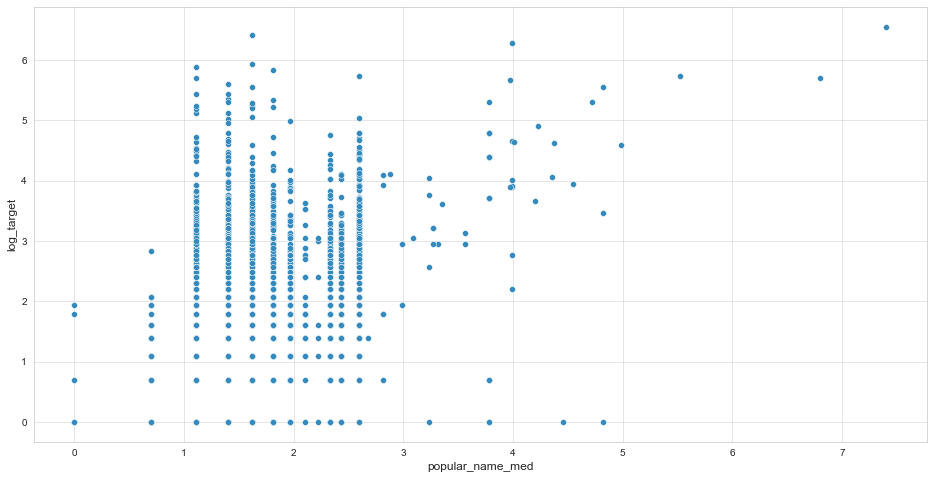

In [102]:
# popular_name_med
plt.figure(figsize=(16, 8))
sns.scatterplot(x='popular_name_med', y='log_target', data=sample_train_df, palette='Blues_d')

<AxesSubplot:xlabel='town_id_med', ylabel='log_target'>

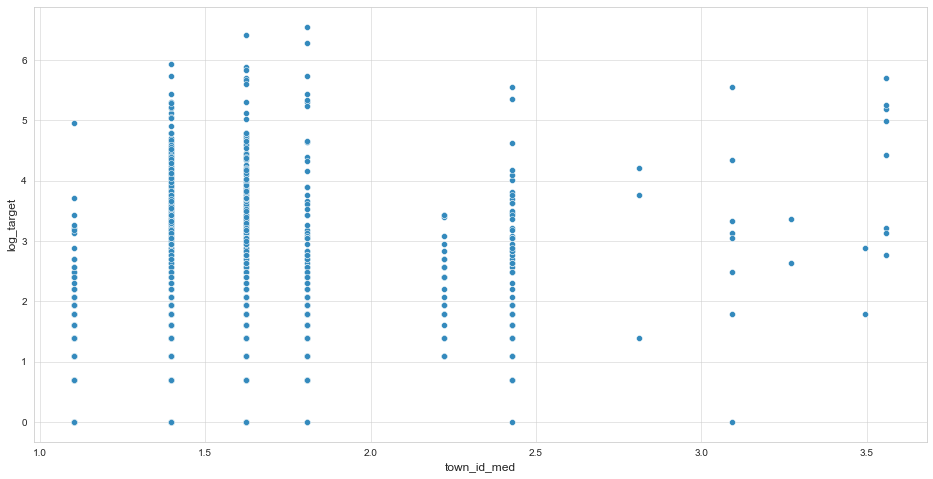

In [103]:
# town_id_med
plt.figure(figsize=(16, 8))
sns.scatterplot(x='town_id_med', y='log_target', data=sample_train_df, palette='Blues_d')

<AxesSubplot:xlabel='ruta_id_med', ylabel='log_target'>

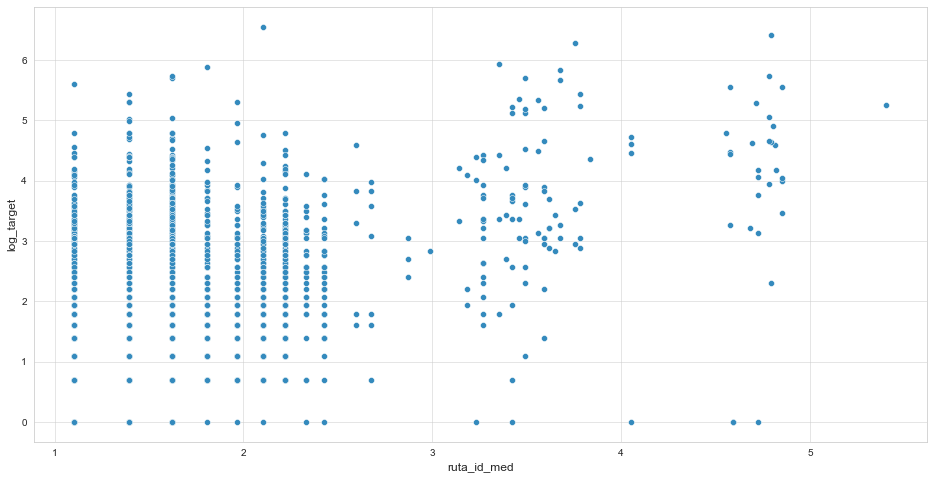

In [104]:
# ruta_id_med
plt.figure(figsize=(16, 8))
sns.scatterplot(x='ruta_id_med', y='log_target', data=sample_train_df, palette='Blues_d')

# 5. Model Building and Evaluation

## 5.1 Importing Packages

In [105]:
'''Importing Modeling Interested Modules'''
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor

## 5.2 Preparation before Building Models 

In [106]:
'''Adjust dataframe for modeling'''
train_y = train_df['Demanda_uni_equil']
train_df.drop(['Demanda_uni_equil'], axis=1, inplace=True)
train_X = train_df
test_X = test_df.drop('id', axis=1)

'''Transform categorical features to dummy variables'''
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)

In [107]:
sample_train_df['Demanda_uni_equil'] = np.expm1(sample_train_df['log_target']).astype('int32')

In [108]:
sample_train_df.head(5)

,Canal_ID,Demanda_uni_equil,weight,price,client_med,popular_name_med,town_id_med,ruta_id_med,log_target
15223982,1,1,4.648,2.163,1.396,1.808,1.622,1.622,0.693
73974594,1,2,4.774,2.180,1.396,1.622,1.396,1.105,1.099
26300021,1,5,4.614,2.001,1.105,1.622,1.396,1.396,1.792
5813796,1,14,4.107,1.401,1.808,2.427,1.396,1.622,2.708
14828839,1,5,4.107,1.401,1.105,2.427,1.396,1.105,1.792


In [109]:
'''Prepare sample train for the fast training'''
sample_train_y = sample_train_df['Demanda_uni_equil']
sample_train_df.drop(['Demanda_uni_equil', 'log_target'], axis=1, inplace=True)
sample_train_X = sample_train_df

sample_train_X = pd.get_dummies(sample_train_X)

In [110]:
'''We should use the log transform of the target value'''
class MyEstimator(BaseEstimator):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        self.model.fit(X, np.log1p(y))
        return self 

    def predict(self, X):
        predicts = np.expm1(self.model.predict(X))
        mask = (predicts <= 0)
        predicts[mask] = 0
        return predicts

In [111]:
'''Define evaluation function for Convienience'''
def evaluation_model(model, train_X, train_y, test_X):
    cv = rmsle_cv(model, train_X, train_y)
    cv_mean = np.round(cv.mean(), 5)
    cv_std = np.round(cv.std(), 5)
    sample_prediction = model.predict(test_X.loc[:3, :])
    return {'cv_mean': cv_mean, 'cv_std': cv_std, 'sample_prediction': sample_prediction}

In [112]:
'''Define Hyperparameters Tuning Function'''
def tune_hyperparameters(model, param_grid, train_X, train_y):
    grid = GridSearchCV(
        model, param_grid, 
        scoring='neg_mean_squared_log_error',
        cv=3, n_jobs=-1,
    )
    grid.fit(train_X, train_y)
    best_params = grid.best_params_ 
    best_score = np.round(np.sqrt(-1 * grid.best_score_), 5)
    return best_params, best_score

## 5.3 Building Models

### LinearRegression

In [113]:
model = make_pipeline(
    RobustScaler(),
    LinearRegression(),
)
lr_model = MyEstimator(model)
lr_model.fit(sample_train_X, sample_train_y)
lr_eval = evaluation_model(lr_model, sample_train_X, sample_train_y, test_X)
print(lr_eval)

{'cv_mean': 0.57828, 'cv_std': 0.01089, 'sample_prediction': array([3.770215 , 1.3445094, 3.9214249, 1.8789132], dtype=float32)}


### RidgeCV

In [115]:
model = make_pipeline(
    RobustScaler(),
    RidgeCV(
        alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10),
    ),
)
ridge_cv_model = MyEstimator(model)
ridge_cv_model.fit(sample_train_X, sample_train_y)
ridge_cv_eval = evaluation_model(ridge_cv_model, sample_train_X, sample_train_y, test_X)
print(ridge_cv_eval)

opt_alpha = ridge_cv_model.model.steps[1][1].alpha_
print(f'\nopt_alpha: {opt_alpha}')

{'cv_mean': 0.57885, 'cv_std': 0.01123, 'sample_prediction': array([3.77195289, 1.35317079, 3.91987441, 1.88055039])}

opt_alpha: 1.0


### SVR

In [125]:
### build basemodel
model = make_pipeline(
    RobustScaler(),
    SVR(),
)
svr_model = MyEstimator(model)

### optimize hyperparameters
param_grid = {'model__svr__C': [1, 10, 20],
              'model__svr__epsilon': [0.001, 0.01, 0.1],
              'model__svr__gamma': [0.0001, 0.001, 0.01]}
best_params, best_score = \
    tune_hyperparameters(svr_model, param_grid, sample_train_X, sample_train_y)

### fit using best_params
svr_model.set_params(**best_params)
svr_model.fit(sample_train_X, sample_train_y)
svr_eval = evaluation_model(svr_model, sample_train_X, sample_train_y, test_X)
print(svr_eval)

print(f'\ngrid best_params: {best_params}')

{'cv_mean': 0.56967, 'cv_std': 0.00858, 'sample_prediction': array([3.9571917 , 1.33300058, 3.46769293, 1.87970667])}

grid best_params: {'model__svr__C': 20, 'model__svr__epsilon': 0.01, 'model__svr__gamma': 0.01}


### KernelRidge

In [120]:
### build basemodel
model = make_pipeline(
    RobustScaler(),
    KernelRidge(),
)
kr_model = MyEstimator(model)

### optimize hyperparameters
param_grid = {'model__kernelridge__alpha': [0.01, 0.1, 0.5, 1],
              'model__kernelridge__kernel': ['linear', 'polynomial'],
              'model__kernelridge__degree': [1, 1.5, 2, 3],
              'model__kernelridge__coef0': [3, 4, 5]}
best_params, best_score = \
    tune_hyperparameters(kr_model, param_grid, sample_train_X, sample_train_y)

### fit using best_params
kr_model.set_params(**best_params)
kr_model.fit(sample_train_X, sample_train_y)
kr_eval = evaluation_model(kr_model, sample_train_X, sample_train_y, test_X)
print(kr_eval)

print(f'\ngrid best_params: {best_params}')

{'cv_mean': 0.56714, 'cv_std': 0.00995, 'sample_prediction': array([4.03321938, 1.23027878, 3.62322514, 1.62942388])}

grid best_params: {'model__kernelridge__alpha': 1, 'model__kernelridge__coef0': 3, 'model__kernelridge__degree': 2, 'model__kernelridge__kernel': 'polynomial'}


### LightGBM

In [126]:
model = LGBMRegressor(learning_rate=0.01, n_estimators=3000,
                      num_leaves=5,
                      objective='regression',
                      max_bin=55, bagging_fraction=0.8,
                      bagging_freq=5, feature_fraction=0.2319,
                      feature_fraction_seed=9, bagging_seed=9,
                      min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
lgb_model = MyEstimator(model)
lgb_model.fit(sample_train_X, sample_train_y)
lgb_eval = evaluation_model(lgb_model, sample_train_X, sample_train_y, test_X)
print(lgb_eval)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

## 5.4 Submission

In [122]:
def output_submission_file(model, test_X, filename='submission.csv'):
    prediction = model.predict(test_X)
    df = pd.DataFrame({'id': test_df['id'], 'Demanda_uni_equil': prediction})
    print(f'{df.shape}')
    print(f'{df.head(5)}')
    df.to_csv(filename, index=False)
    df.to_csv(filename + '.gz', index=False, compression='gzip')

In [123]:
'''Submission'''
output_submission_file(lgb_model, test_X)

(6999251, 2)
   id  Demanda_uni_equil
0   0              4.063
1   1              1.467
2   2              3.360
3   3              1.591
4   4              2.165
